### Runnable и LangChain Expression Language
**Runnable** - это интерфейс в Langchain, который наследует большая часть объектов

Основные характеристики:
- есть метод invoke
- поддерживает пакетную обработку нескольких входов параллельно (batch и batch_as_completed)
- поддерживает потоковую выдачу результатов по мере генерации (stream)
- позволяет композировать несколько элементов для создания сложных конвейеров

**LCEL** - это язык выражений в LangChain предназначенный для создания цепочек
Звенья цепочки записываются через | . Сама цепочка становится Runnable

**Стандартные методы**:
- invoke - обрабатывает один запрос
- batch - обрабатывает список запросов
- stream - выдает ответ в формате стриминга (видишь как модель генерит ответ)

In [11]:
import os
from getpass import getpass
from langchain_openai import ChatOpenAI

course_api_key = getpass(prompt='Введите ваш  API-ключ курса')

llm = ChatOpenAI(api_key=course_api_key, model='gpt-4o-mini', 
                 base_url="https://aleron-llm.neuraldeep.tech/")

In [2]:
from langchain.prompts import PromptTemplate

template = """Перепиши этот текст в заданном стиле: {input_text}
Стиль: {style}.
Результат:"""

prompt = PromptTemplate(input_variables=['input_text','style']
                        ,template=template)

style_changer_chain = prompt | llm #Создание цепочки

In [ ]:
text = '''Приветствуем на курсе по тюнингу языковых моделей! 
Тут мы учим, как сделать модельки еще круче и раскрыть их потенциал до максимума. 
Мы дадим вам советы по самым свежим методам обучения и настройки языковых моделей, 
а также научим практическим навыкам для решения сложных задач в обработке естественного языка.'''
style = 'Роман 18 века'

answer = style_changer_chain.invoke(
    {
        'input_text':text
        ,'style': style
    }
) #Вызываем ответ на запрос у цепочки


content='Приветствуем вас, благородные искатели знаний, на нашем курсе, посвящённом искусству совершенствования языковых моделей! Здесь, в светлых залах учёного братства, мы приоткроем завесу тайны над тем, как возвысить эти умные творения до пределов их величайшего могущества. \n\nС радостью поделимся с вами мудростью о самых современных методах обучения и неимоверной настройки наших языковых спутников. Мы также осна\xadстим вас практическими навыками, которые позволят с лёгкостью решать непростые задачи, возникающие в волшебном мире обработки естественного языка. Пусть ваше стремление к познанию будет безграничным, и да приведут вас наши учения к славным вершинам успеха!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 176, 'prompt_tokens': 111, 'total_tokens': 287, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_token

In [4]:
print(answer.content)

Приветствуем вас, благородные искатели знаний, на нашем курсе, посвящённом искусству совершенствования языковых моделей! Здесь, в светлых залах учёного братства, мы приоткроем завесу тайны над тем, как возвысить эти умные творения до пределов их величайшего могущества. 

С радостью поделимся с вами мудростью о самых современных методах обучения и неимоверной настройки наших языковых спутников. Мы также осна­стим вас практическими навыками, которые позволят с лёгкостью решать непростые задачи, возникающие в волшебном мире обработки естественного языка. Пусть ваше стремление к познанию будет безграничным, и да приведут вас наши учения к славным вершинам успеха!


In [ ]:
style_changer_chain.batch([{'input_text': text, 'style': style},
                           {'input_text': text, 'style': 'поэма'}])

In [ ]:
# метод stream возвращает генератор
# style_changer_chain.stream({'input_text': text, 'style': 'поэма'})

In [ ]:
# Просто импортируем парсер и добавляем его, как ещё 1 звено цепочки
from langchain.schema.output_parser import StrOutputParser

chain_with_parser = prompt | llm | StrOutputParser() # И ВСЁ!

print(chain_with_parser.invoke({'input_text': text, 'style': style}))

#На замену .content

Приветствуем вас, любезные гости, на нашем изысканном курсе, посвященном искусству усовершенствования языковых моделей! Здесь мы предстанем перед вами с намерением раскрыть все тайны, позволяющие возвысить указанные модельки до небывалых высот их потенциала. Мы поделимся с вами мудростью самых современных методов обучения и настройки, а также обучим вас умениям, необходимым для преодоления самых изощренных трудностей в царстве обработки естественного языка. Пусть наш путь будет озарён светом знаний и благородных стремлений!


### TransformChain
**TransformChain** - цепочки в которых используются свои звенья

In [6]:
import re

def del_spaces(inputs: dict) -> dict:
    """Функция принимает словарь с текстом и стилем и чистит текст

    Parameters
    ----------
    inputs
        Словарь с ключом - имя переменнов в шаблоне, значение - текст

    Returns
    -------
        _description_
    """
    text = inputs["input_text"]
    style = inputs["style"]

    text = re.sub(r'(\r\n|\r|\n){2,}', r'\n', text)
    text = re.sub(r'[ \t]+', ' ', text)

    return {"input_text": text, 'style' : style}

In [7]:
# Возьмём наш предыдущий текст и "загрязним его"
dirty_text = '''Приветствуем на курсе по        тюнингу языковых        моделей! 

Тут мы учим, как сделать модельки еще круче и раскрыть     их потенциал до максимума. 
Мы дадим вам советы по   самым свежим методам  обучения и настройки языковых                    моделей,

а также научим практическим навыкам для        решения сложных задач в обработке естественного языка.'''

In [8]:
seq_chain = del_spaces | prompt | llm | StrOutputParser()

answer = seq_chain.invoke({'input_text': dirty_text
                           ,'style' : 'Рэп'})

print(answer)

Здорово, народ, на курсе по тюнингу моделей,  
Здесь мы кайфуем, прокачаем их до предела,  
Раскроем потенциал, сделаем всё круче,  
С новейшими методами, здесь нас не смущает скука.  

Дадим тебе советы, что на пике трендов,  
Настройка, обучение — все секреты, как на стенде.  
Учим тебя навыкам, решения сложных задач,  
В мире NLP — ты будешь как шеф, не иначе!


### Вложенные цепочки


In [30]:
from operator import itemgetter
from langchain.prompts import ChatPromptTemplate

prompt1 = ChatPromptTemplate.from_template("В каком городе родился {person}?")
prompt2 = ChatPromptTemplate.from_template("В какой стране находится город {city}? Ответь на {language} языке")

chain1 = prompt1 | llm | StrOutputParser() #Эта штука ответит нам и даст название города

chain2 = ({"city": chain1, "language": itemgetter("language")}
          | prompt2
          | llm
          | StrOutputParser()) #В эту штуку сначала попадет ответ от первого промта, а потом пойдет второй промт

result = chain2.invoke({"person": "Толстой", "language": "белорусском"})

print(result)
#Горад, у якім нарадзіўся Лев Мікалаевіч Толстой,
#  знаходзіцца ў Расіі, у Тульскай губерніі,
#  у маёнтку Ясная Паляна. Такім чынам, можна сказаць,
#  што ён нарадзіўся ў Яснай Паляне, якая размешчана недалёка ад горада Тула.



NameError: name 'StrOutputParser' is not defined

### Router Chain
**Router Chain** - это когда у нас есть 2 и более модели, каждая из которых шарит в своей теме. Перед тем как отправить запрос
в одну из моделей, мы автоматом определяем тему

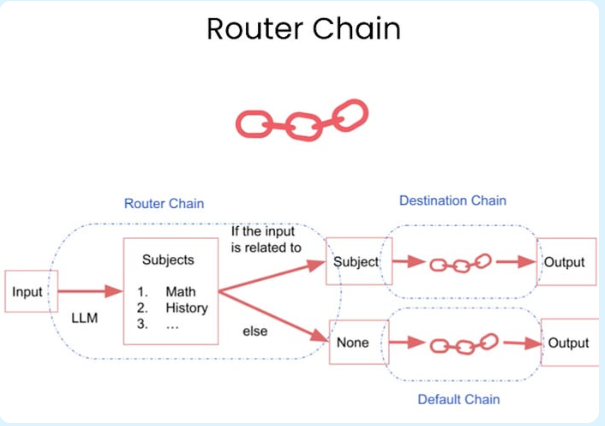

In [9]:
from typing import Literal
from langchain.schema.runnable import RunnableBranch, RunnablePassthrough
from langchain.output_parsers.openai_functions import PydanticAttrOutputFunctionsParser
from pydantic import BaseModel
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

In [2]:
botanist_template = """Ты очень опытный флорист и ботаник, знаешь всё о цветах, растениях.
Тебе нравится отвечать на вопросы о том, как выбирать и ухаживать за растениями. 
Ты отвечаешь так, что всё становится ясно даже начинающему цветоводу. 
Вот вопрос:
{input}"""

football_template = """Ты спортивный журналист с большим опытом, твоя основная специализация футбол.
Ты знаешь всё о футбольных командах и игроках, и очень любишь отвечать на вопросы о футболе, но кратко и по делу.
Вот вопрос:
{input}"""

In [5]:
# Создаём промпты
botanist_prompt = PromptTemplate.from_template(botanist_template)
football_prompt = PromptTemplate.from_template(football_template)

# Создаём ветки
prompt_branch = RunnableBranch(
    (lambda x: x["topic"] == "botany", botanist_prompt),
    (lambda x: x["topic"] == "football", football_prompt),
    PromptTemplate.from_template("Answer the question: {input}"),
)

In [ ]:
#Класс для определения темы
class TopicClassifier(BaseModel):
    "Classify the topic of the user question"

    topic: Literal["botany", "football", "general"]
    "The topic of the user question. One of 'botany', 'football' or 'general'."


#Создаем классификатор
classifier_function = convert_to_openai_function(TopicClassifier)

#Создаем модель
model = ChatOpenAI(api_key=course_api_key, base_url="https://aleron-llm.neuraldeep.tech/").bind(
    functions=[classifier_function],
    model="gpt-4o-mini",
    function_call={"name": "TopicClassifier"}
)

#Создаем парсер чтобы определять тему
parser = PydanticAttrOutputFunctionsParser(pydantic_schema=TopicClassifier, attr_name="topic")

classifier_chain = model | parser

In [26]:
# Посмотрим как работает цепочка-классификатор тем
classifier_chain.invoke("Какие цвета у Барселоны?")

'football'

In [27]:
classifier_chain.invoke("Сколько раз в неделю поливать кактус?")

'botany'

In [31]:
from langchain.schema.output_parser import StrOutputParser

# Собираем цепочку-роутер
router_chain = (
    RunnablePassthrough.assign(topic=itemgetter("input") | classifier_chain)
    | prompt_branch | llm | StrOutputParser()
)

# Здесь происходит следующее:
# - сначала определяется тема
# - далее prompt_branch принимает тему и по ней определяет какой эксперт должен это
# - потом уже идет вывод

In [ ]:
router_chain.invoke({'input': "Какие цвета у Барселоны?"})

#Модель определила тему и пошла по своей ветке

'Цвета футбольного клуба Барселона — это синее и гранатовое (темно-красное). Эти цвета стали символом клуба и его болельщиков.'